### Step 1
Activate the Plastid conda environment and open up a Jupyter Lab session (alternatively, a python file can be run in this python environment)

### Step 2
Load in all of the necessary Python packages.

In [2]:
# Let the program know where to find your tools file.
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [22]:
# Load up the necessary packages 
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from decimal import Decimal
from plastid.plotting.plots import *
from scipy import stats
from scipy.stats import kstwo
from statsmodels.stats.proportion import proportions_ztest
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.stats.multitest import multipletests
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr
from tqdm import tqdm
from multiprocess import Pool
import copy
import seaborn as sns

In [4]:
# Define the path to our data files and the path we want to save our outputs in. 
target_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/Fmr1_targets/'
ks_dmel_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/dmel/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/Figures/reviewer_figures/'
samp_num = '2'

### Step 3
Load up a table containing a list of targets for your mutant gene and load up the KS table you created during the previous section using pandas pd.read_csv().

In [5]:
# Load up the target gene names. 
Fmr1_table = pd.read_csv(target_path + 'Fmr1_dmel_downreg_genes.txt', names = ["gene_name"])

# Load up the tables of KS statistics
df_dmel = pd.read_csv(ks_dmel_path + "ks_table_" + samp_num + ".csv")

### Step 4
Merge the table of KS statistics and the table of targets into a new table using pd.merge()

In [6]:
# Merge the ecoli ks table with the list of gene names
Fmr1_ks_table = pd.merge(df_dmel, Fmr1_table, how='inner', right_on='gene_name', left_on='gene_ID')

combo_df = pd.merge(df_dmel, Fmr1_table, how='left', right_on='gene_name', left_on='gene_ID')

### Step 5
Clean up your new table by removing any duplicates that may have been caused by multiple transcripts having the same gene name. 

In [7]:
# Keep only one copy of each gene in the Fmr1 table. 
Fmr1_ks_table.drop_duplicates(subset ="gene_name",keep = "first", inplace = True) 

df_dmel.drop_duplicates(subset ="gene_ID",keep = "first", inplace = True) 

combo_df.drop_duplicates(subset ="gene_ID",keep = "first", inplace = True) 

In [8]:
Fmr1_ks_table = Fmr1_ks_table.sort_values(by = "ks_stat")
df_dmel = df_dmel.sort_values(by = "ks_stat")
combo_df = combo_df.sort_values(by = "ks_stat")

Fmr1_ks_table = Fmr1_ks_table.reset_index(drop = True)
df_dmel = df_dmel.reset_index(drop = True)
combo_df = combo_df.reset_index(drop = True)

### Step 6
Look at the KS statistic from the control mutant comparisons for all genes and for just the Fmr1 targets. This will help you get an initial sense for how you want to divide up the low, medium, and high KS fractions. For both the merged table and the original table of KS statistics, sort the KS values from smallest to largest using the sorted() function and then plot them as a scatter plot.

(0.0, 0.7)

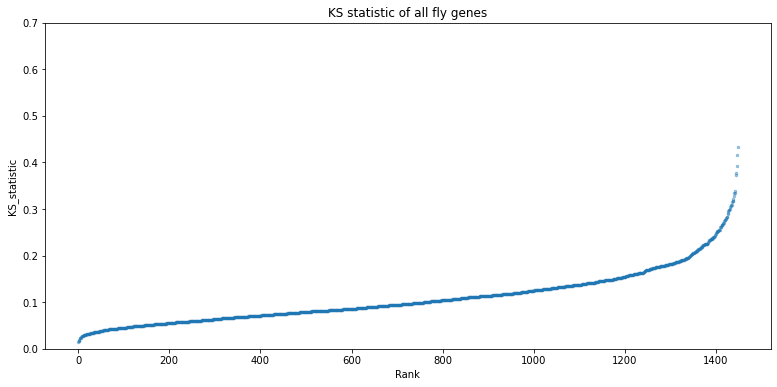

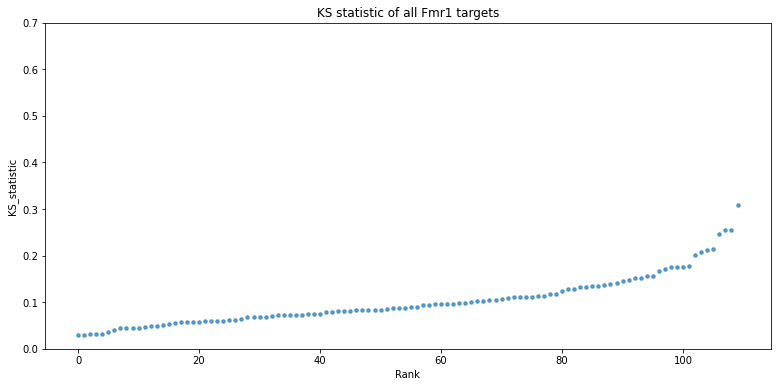

In [9]:
# Plot the KS values for each gene from lowest to highest. 
figure(figsize = (13,6))
plt.scatter(list(range(len(df_dmel["ks_stat"]))), sorted(df_dmel["ks_stat"]), s=6, alpha = 0.4)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all fly genes")
plt.ylim(0,0.7)
plt.show
figure(figsize = (13,6))
plt.scatter(list(range(len(Fmr1_ks_table["ks_stat"]))), sorted(Fmr1_ks_table["ks_stat"]), s=12, alpha = 0.7)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all Fmr1 targets")
plt.ylim(0,0.7)

In [10]:
targets = combo_df.dropna()

non_targets = combo_df[combo_df["gene_name"].isnull()]

<Figure size 936x432 with 0 Axes>

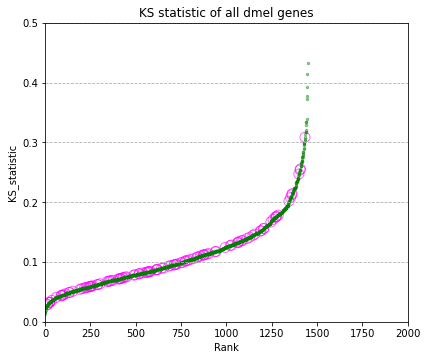

In [12]:
figure(figsize = (6.5,5.5))
plt.scatter(list(targets.index), targets["ks_stat"], s=100, alpha = 0.6, facecolors = 'none', edgecolors = 'magenta')
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all EFP targets")

plt.scatter(list(non_targets.index), non_targets["ks_stat"], s=6, alpha = 0.4, color = "g")
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all dmel genes")
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.ylim(0,0.5)
plt.xlim(0,2000)
plt.savefig(save_path + 'dmel_all_gene.pdf', bbox_inches = "tight")

In [13]:
# print out the mean of all polyprolne motif containing genes (efp targets)
print("mean KS statistic of Fmr1 target genes = " + str(np.mean(Fmr1_ks_table.ks_stat)))
print("mean KS statistic of all D.mel genes = " + str(np.mean(df_dmel.ks_stat)))

mean KS statistic of Fmr1 target genes = 0.10208611457519755
mean KS statistic of all D.mel genes = 0.10927106107666991


### Step 7
Calculate the upper KS statistic by taking the average KS stat of the top 10% of transcripts with the highest KS stat. transcripts that have a higher KS statistic then the upper KS statistic will be within the high KS fraction. Then we choose the number of fractions we would like to observe. Then we use the determine_enrichment() function to determine the ratio between the targets and the total genes within each KS fraction.

In [14]:
# Calculate the upper KS value as the average of the 10% of transcripts with the highest KS stat. 
# The upper KS fraction will include all of the transcripts with a KS score above this value.
upper_ks = 0.3

# Calculate the proportion of genes which are Fmr1 targets in a high, medium, and low KS fraction
N_cats = 2
enrich_dmel, sections_dmel = kat.determine_enrichment(targets, non_targets, upper_ks, N_cats)

In [15]:
enrich_dmel

[1.0285427807486631, 0.8836829836829836, 0.7602272727272726]

### Step 8
Now we want to perform Fisher's exact test to determine if the difference between our observed and expected target proportions are significant. We can use the Fisher_exact_p_values() function to automatically calculate these P-values for each of the KS fractions.

In [17]:
# determine if the difference betwqeen the expected proportion of targets 
# and the observed proportion of targets is significant
p_values = kat.Fisher_exact_p_values(targets, non_targets, sections_dmel)

In [18]:
p_values

[0.6108682019643761, 0.6943645286357785, 1.0]

In [19]:
multipletests(p_values,method = "fdr_bh")

(array([False, False, False]),
 array([1., 1., 1.]),
 0.016952427508441503,
 0.016666666666666666)

### Step 9
Use matplotlib.pyplot.bar() function to create a series of barplots that show the observed percentage of genes that are targets in each fraction. Then you can draw a a line through this barplot using matplotlib.pyplot.plot() that shows the expected percentage of genes that are targets if there is no enrichment.  

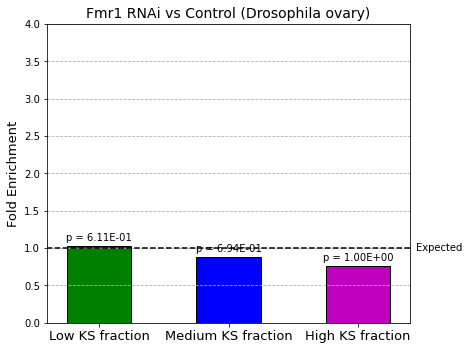

In [24]:
# Create a bar plot that shows the proportion of genes which are Fmr1 targets in each KS fraction.
figure(figsize = (6.5,5.5))
bps = plt.bar([1,2,3],enrich_dmel, width = 0.5,
        tick_label = ["Low KS fraction","Medium KS fraction","High KS fraction"], 
       color = ["g", 'b', 'm'], edgecolor = 'black')
plt.xticks(fontsize = 13)
plt.xlim(0.6,3.4)
plt.ylim(0, 4)
plt.text(3.45, 0.96, "Expected", fontsize = 10)
plt.ylabel("Fold Enrichment", fontsize = 13)
plt.title("Fmr1 RNAi vs Control (Drosophila ovary)", fontsize = 14)
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")

for b, p in zip(bps, p_values):
    height = b.get_height()
    plt.annotate("p = " + "{}".format("%.2E" % Decimal(p)),
      xy=(b.get_x() + b.get_width() / 2, height),
      xytext=(0, 3), textcoords="offset points",
      ha="center", va="bottom")

# Create a line showing the expected proportion of targets. 
plt.plot([0,6],[1,1], color = "black", linestyle = "--")
plt.savefig(save_path + 'dmel_proportions.pdf', bbox_inches = "tight")

## Plot the distribution of the KS-statistic for all genes and for the target genes. 

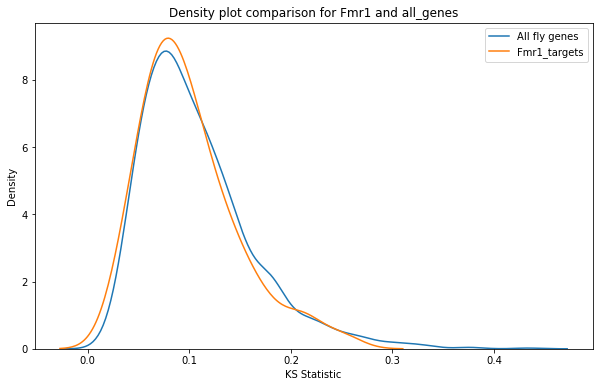

In [18]:
figure(figsize = (10,6))
sns.kdeplot(df_dmel.ks_stat, label = "All fly genes")
sns.kdeplot(Fmr1_ks_table.ks_stat, label = "Fmr1_targets")
plt.ylabel("Density")
plt.xlabel("KS Statistic")
plt.title("Density plot comparison for Fmr1 and all_genes")
plt.legend()

In [19]:
targets

,gene_ID,ks_stat,gene_length,gene_name
13,Col4a1,0.028676,1780,Col4a1
14,Gp150,0.028707,1052,Gp150
23,pAbp,0.032080,635,pAbp
26,eEF1alpha1,0.032519,464,eEF1alpha1
27,EMC1,0.032701,909,EMC1
...,...,...,...,...
1383,RpL23A,0.212385,278,RpL23A
1385,HmgZ,0.214231,112,HmgZ
1394,RpL22,0.219676,300,RpL22
1423,CG15083,0.247052,151,CG15083


In [20]:
targets.drop(["gene_name", "gene_length"], axis = 1, inplace = True)

---------------------------------------------------------------------------
SettingWithCopyWarning

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
in /home/keeganfl/miniconda3/envs/plastid/lib/python3.8/site-packages/pandas/core/frame.py, line 4906:

4904                 weight  1.0     0.8
4905         """
4906         return super().drop(
4907             labels=labels,
4908             axis=axis,

---------------------------------------------------------------------------


In [21]:
targets.to_csv("/home/keeganfl/Desktop/measuring_binding_domains/Extra_tables/dmel_fmr1_ks_stats.csv",index = False)